In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import jax
os.chdir("..")

# Load Data

In [6]:
path = "/stelmo/sam/c3po_datasets/sub-Han_desc-train_behavior+ecephys.nwb"

# nwb file
os.path.exists(path)
io = NWBHDF5IO(path, "r")
nwbfile = io.read()

# behavior data
data = []
for object in nwbfile.objects.values():
    if isinstance(object, TimeSeries):
        if "hand" in object.name.lower() or "hand" in object.description.lower():
            data.append(object)
behavior_df = {}
for d in data:
    for i, dim in enumerate(["x", "y"]):
        behavior_df[f"{d.name}_{dim}"] = d.data[:, i]
behavior_df = pd.DataFrame(behavior_df, index=d.get_timestamps())
trials_df = nwbfile.trials.to_dataframe()

# spikes
units_df = nwbfile.units.to_dataframe()

t_spike = []
id_spike = []
for i, spikes in enumerate(units_df["spike_times"]):
    t_spike.extend(spikes)
    id_spike.extend([i] * len(spikes))
ind = np.argsort(t_spike)
t_spike = np.array(t_spike)[ind]
id_spike = np.array(id_spike)[ind]

delta_t = np.diff(t_spike) * 1000  # convert to ms
waveforms = id_spike[1:].astype(np.int16)

ind_valid = np.where(delta_t > 0)[0]
delta_t = delta_t[ind_valid]
waveforms = waveforms[ind_valid]

delta_t.shape, waveforms.shape

np.mean(delta_t), np.std(delta_t), (t_spike.max() - t_spike.min()) / 60

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


(2.78305990204288, 2.57739697813634, 37.05741666666667)

# Load in embedding results

In [5]:
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()  # .alter()
key = {"model_name": "monkey_s1_bump_reach_REACH_ONLY"}
analysis = (C3POStorage & key).fetch_analysis_object()

analysis.load_embedding(f"/stelmo/sam/c3po_results/{key['model_name']}_embedding.npz")

t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

# Just showing how to access the variables
t = analysis.t
z = analysis.z
c = analysis.c
c_pca = analysis.c_pca
t_interp = analysis.t_interp
c_interp = analysis.c_interp
c_pca_interp = analysis.c_pca_interp
latent_dim, context_dim = analysis.latent_dim, analysis.context_dim

In [3]:
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage() & "model_name LIKE  'monkey%'"

*model_name    encoder_ar context_ar rate_args  latent_dim     context_dim    input_shap learned_pa
+------------+ +--------+ +--------+ +--------+ +------------+ +------------+ +--------+ +--------+
monkey_s1_bump =BLOB=     =BLOB=     =BLOB=     16             8              =BLOB=     =BLOB=    
monkey_s1_bump =BLOB=     =BLOB=     =BLOB=     16             8              =BLOB=     =BLOB=    
monkey_s1_bump =BLOB=     =BLOB=     =BLOB=     16             16             =BLOB=     =BLOB=    
 (Total: 3)

# Analyze

## Spectrogram

In [7]:
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
# val = val[val.cond_dir == direction]
# val = val[val.split != "none"]
starts = val.move_onset_time.values

reach_intervals = np.array([starts - 1, starts + 1.5]).T

f, mid, lo, hi = analysis.power_spectrum(
    window_size=1000, nfft=20000, intervals=reach_intervals, pca=True
)

(0.0, 30.0)

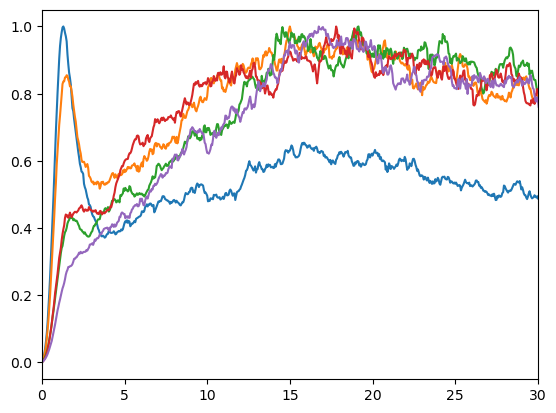

In [9]:
y_plot = mid.T * f[:, None]
y_plot = y_plot / y_plot.max(axis=0)

y_plot = y_plot[:, :5]

plt.plot(f, y_plot)
# plt.xscale('log')
plt.xlim(0, 30)

In [176]:
y_plot.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Cross correlation

In [ ]:
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
starts = val.move_onset_time.values
starts = starts[~np.isnan(starts)]
reach_intervals = np.array([starts - 0.3, starts + 1]).T

lags, xcorr = analysis.cross_correlation(
    max_lag_seconds=0.1, dim_limit=10, processes=20, intervals=reach_intervals
)

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 100/100 [00:05<00:00, 19.83it/s]


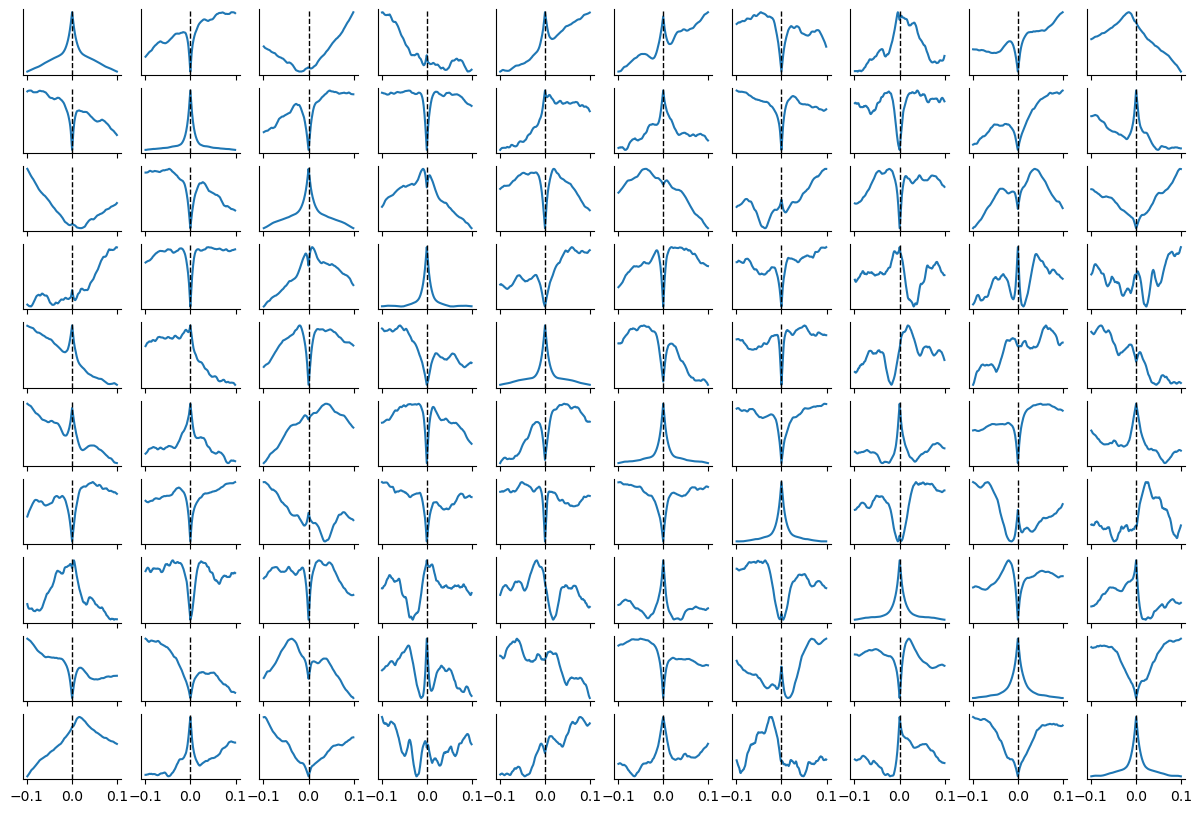

In [ ]:
t_rng = (-0.02, 0.02)
t_rng = (-0.05, 0.05)
# t_rng = -0.1, 0.1
t_rng = -0.2, 0.2
# t_rng = -1,1
# t_rng = -.2,.2

n_plot = 10

n_plot = min(n_plot, xcorr.shape[0])

ind_plot = np.where((lags >= t_rng[0]) & (lags <= t_rng[1]))[0]


fig, ax = plt.subplots(nrows=n_plot, ncols=n_plot, figsize=(15, 10), sharex=True)

for i in range(n_plot):
    for j in range(n_plot):
        ax[i, j].plot(lags[ind_plot], xcorr[i, j][ind_plot])
        ax[i, j].spines[["top", "right"]].set_visible(False)
        # ax[i,j].set_title(f"PC {i+1} vs PC {j+1}")
        ax[i, j].axvline(0, c="k", ls="--", lw=1)
        ax[i, j].set_yticks([])
# plt.xlim(-.1,.1)
# plt.yscale('log')

## Response Curves

8


(-1.0, 3.0)

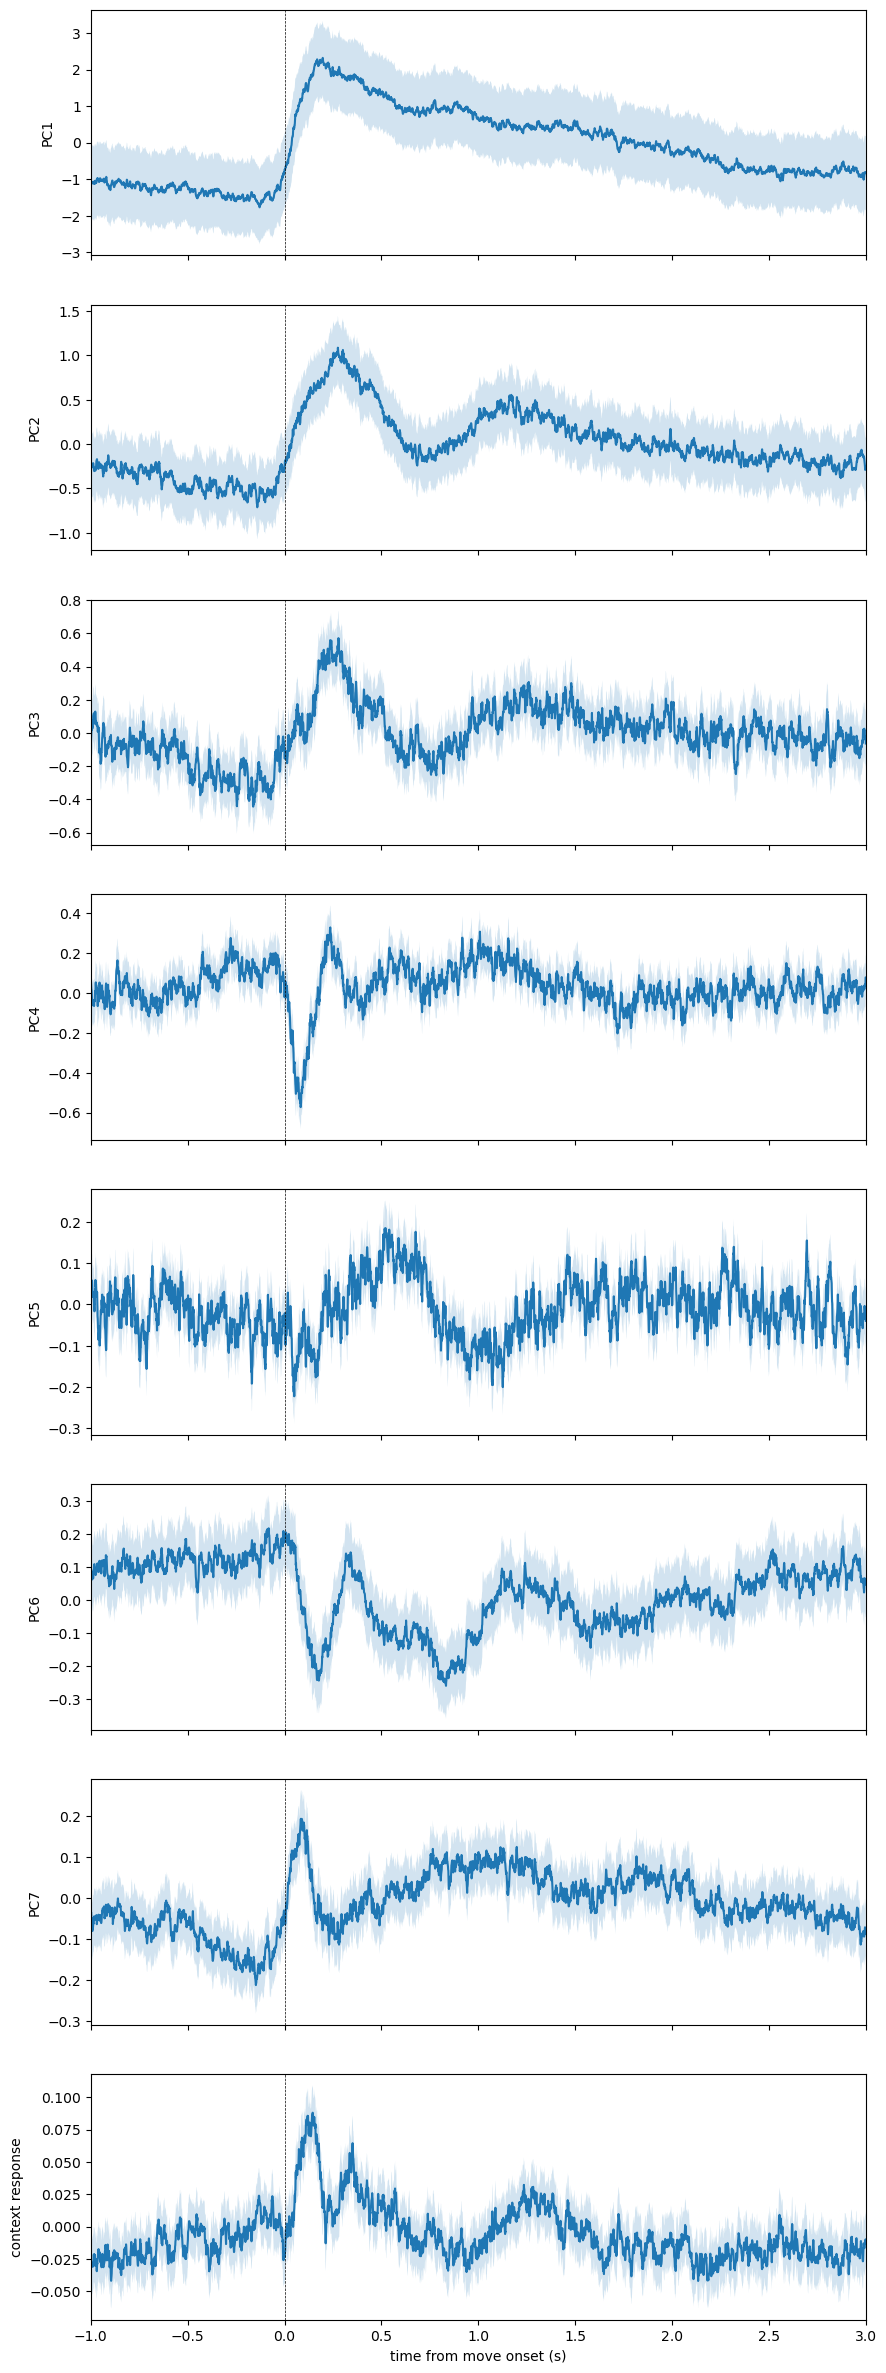

In [10]:
start_times = trials_df.move_onset_time.values
t_rng = (-1, 3)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 30))


response = analysis.alligned_response(start_times, t_rng, pca=True)

response.shape
response = np.mean(response, axis=0)

t = np.linspace(t_rng[0], t_rng[1], response.shape[0])
for i, a in enumerate(ax):
    a.plot(
        t,
        response[:, i],
        label=f"PC{i+1}",
    )
    a.fill_between(
        t,
        response[:, i] - np.std(response[:, i]),
        response[:, i] + np.std(response[:, i]),
        alpha=0.2,
    )
    a.set_ylabel(f"PC{i+1}")
    a.axvline(0, color="k", lw=0.5, ls="--")
# plt.plot(
#     t,
#     response[:, :],
# )
# response = np.array([smooth(response[:, i], 100) for i in range(response.shape[-1])]).T


# plt.plot(response[:, 0], response[:, 1], lw=1)
# plt.scatter(response[0, 0], response[0, 1], s=100, alpha=1,c='k')
# plt.xlabel("PC1")
# plt.ylabel("PC2"    )
print(context_dim)
plt.xlabel("time from move onset (s)")
plt.ylabel("context response")
plt.xlim(t_rng)

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


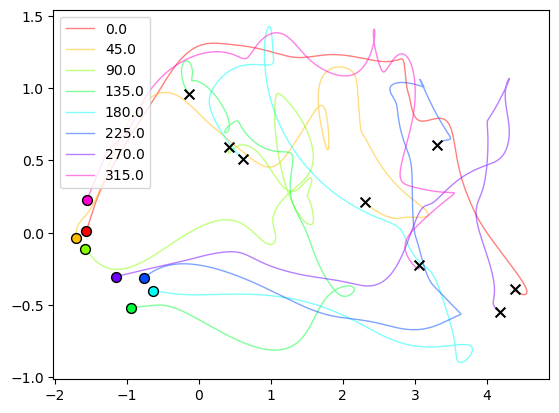

In [11]:
t_rng = (-0.1, 0.5)
# t_rng = (-0.5, 1)
plot_dims = (3, 4)
plot_dims = (0, 1)
plot_dims = (0, 2)
# plot_dims = (1, 4)
smooth_len = 101


def smooth(x, window_len=11, window="hamming"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window == "hanning":
        w = np.hanning(window_len)
    elif window == "hamming":
        w = np.hamming(window_len)
    elif window == "blackman":
        w = np.blackman(window_len)
    elif window == "gaussian":
        w = np.hanning(window_len)
        w = np.exp(
            -0.5
            * (np.arange(window_len) - window_len // 2) ** 2
            / (window_len // 6) ** 2
        )
        w /= w.sum()
    else:
        raise ValueError("Window is on of 'hanning', 'hamming', 'blackman'")
    y = np.convolve(w / w.sum(), x, mode="valid")
    return y


for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    # color=None
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    # val = trials_df[np.logical_and(trials_df.target_dir == direction, trials_df.result =='A')]
    # val = trials_df[
    #     trials_df.target_dir == direction
    # ]
    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=smooth_len, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    # plt.plot(response[:, 0], label=direction)
    plt.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        label=direction,
        lw=1,
        color=color,
        alpha=0.5,
    )
    plt.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    plt.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )
    plt.legend()

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


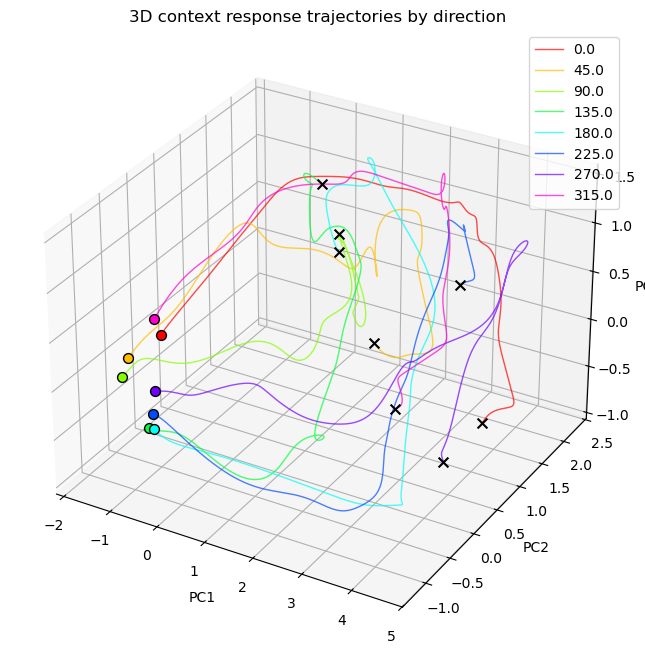

In [13]:
from mpl_toolkits.mplot3d import Axes3D

plot_dims = (0, 1, 2)
# plot_dims = (1, 2, 3)
t_rng = (-0.1, 0.5)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.mean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=101, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    ax.plot(
        response[:, plot_dims[0]],
        response[:, plot_dims[1]],
        response[:, plot_dims[2]],
        label=direction,
        lw=1,
        color=color,
        alpha=0.7,
    )
    ax.scatter(
        response[0, plot_dims[0]],
        response[0, plot_dims[1]],
        response[0, plot_dims[2]],
        s=50,
        alpha=1,
        color=color,
        zorder=20,
        edgecolor="k",
    )
    ax.scatter(
        response[-1, plot_dims[0]],
        response[-1, plot_dims[1]],
        response[-1, plot_dims[2]],
        s=50,
        alpha=1,
        zorder=20,
        marker="x",
        color="k",
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D context response trajectories by direction")
ax.legend()
plt.show()

0.0
45.0
90.0
135.0
180.0
225.0
270.0
315.0
nan


(-0.1, 0.5)

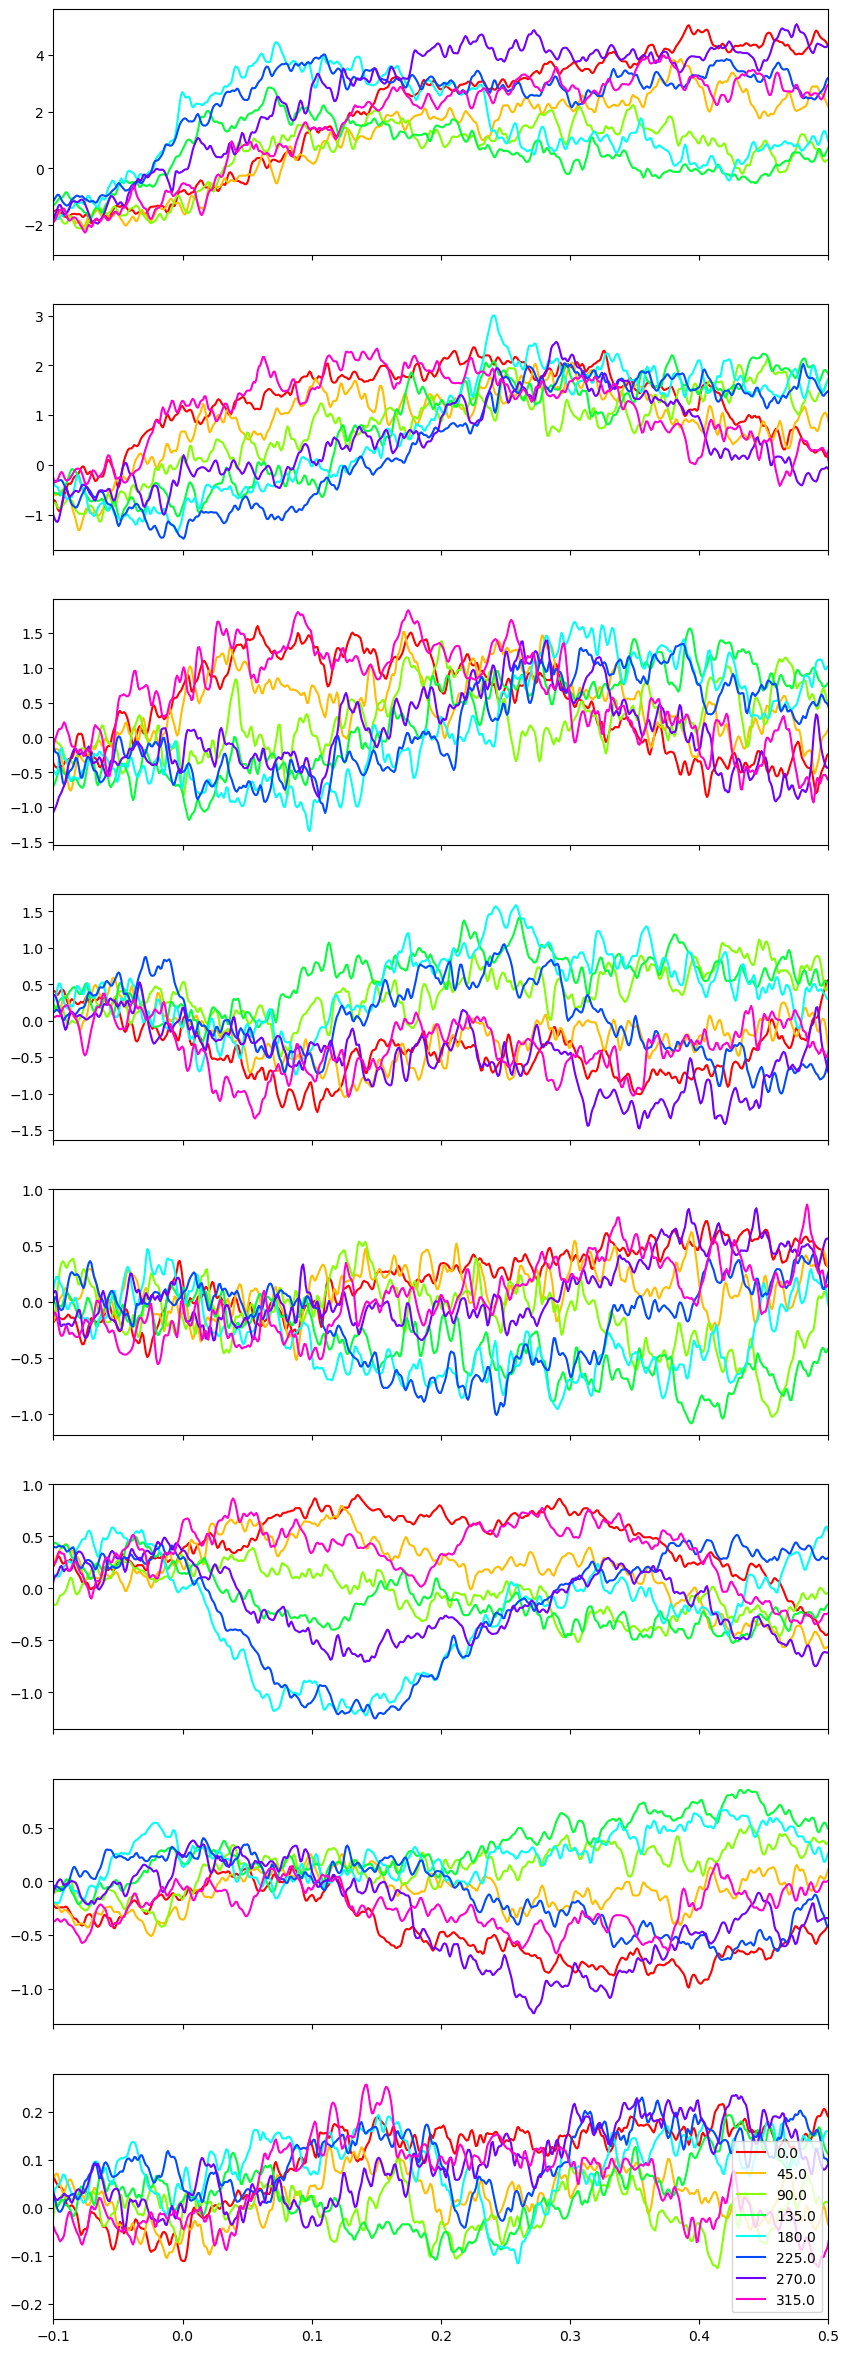

In [14]:
# t_rng = (-0.1, 0.5)
# t_rng = (-0.5, 1)
t_rng = (-0.5, 1.5)
fig, ax = plt.subplots(nrows=context_dim, sharex=True, figsize=(10, 30))


def smooth(x, window_len=11, window="hamming"):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window == "hanning":
        w = np.hanning(window_len)
    elif window == "hamming":
        w = np.hamming(window_len)
    elif window == "blackman":
        w = np.blackman(window_len)
    elif window == "gaussian":
        w = np.hanning(window_len)
        w = np.exp(
            -0.5
            * (np.arange(window_len) - window_len // 2) ** 2
            / (window_len // 6) ** 2
        )
        w /= w.sum()
    else:
        raise ValueError("Window is on of 'hanning', 'hamming', 'blackman'")
    y = np.convolve(w / w.sum(), x, mode="valid")
    return y


for direction in np.unique(trials_df.cond_dir.values):
    print(direction)
    if np.isnan(direction):
        continue
    color = plt.cm.hsv(direction / 360)
    # color = plt.cm.twilight(direction / 360)
    # color = None
    val = trials_df.copy()
    val = val[val.ctr_hold_bump == False]
    val = val[val.cond_dir == direction]
    val = val[val.split != "none"]

    start_times = val.move_onset_time.values
    response = analysis.alligned_response(start_times, t_rng, pca=True)
    response = np.nanmean(response, axis=0)
    response = np.array(
        [
            smooth(response[:, i], window_len=11, window="gaussian")
            for i in range(response.shape[1])
        ]
    ).T
    t_interp_rng = np.linspace(t_rng[0], t_rng[1], response.shape[0])
    for i, a in enumerate(ax):
        a.plot(t_interp_rng, response[:, i], label=direction, color=color)

plt.legend()
plt.xlim(-0.1, 0.5)

## Power spectrums

In [18]:
# starts = trials_df["start_time"].values
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
# val = val[val.cond_dir == direction]
# val = val[val.split != "none"]
starts = val.move_onset_time.values

reach_intervals = np.array([starts - 1, starts + 1.5]).T

In [232]:
f, mid, lo, hi = analysis.power_spectrum(
    intervals=reach_intervals, pca=True, window_size=500
)

Text(0.5, 1.0, 'context power spectrums')

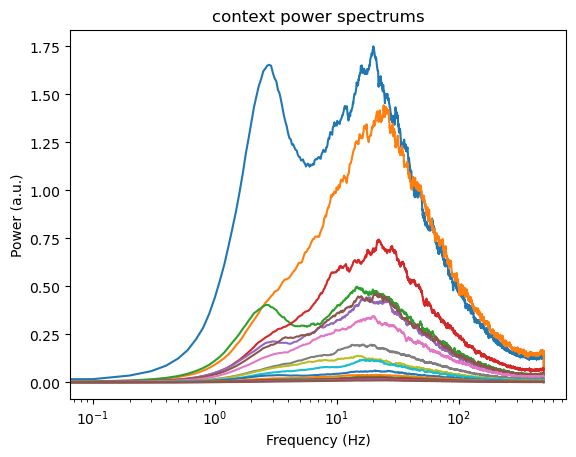

In [233]:
plt.plot(f, mid.T * f[:, None])
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.title("context power spectrums")

# Behavior Decoding

In [ ]:
df = trials_df[trials_df.ctr_hold_bump == False]
reach_intervals = df.move_onset_time.values
train_rng = (-0.1, 0.5)
# train_rng = (-0.1, 1)
train_rng = (-0.5, 1.5)
reach_intervals = np.array(
    [reach_intervals + train_rng[0], reach_intervals + train_rng[1]]
).T

bins = np.linspace(-15, 15, 100)
c_binned, b1, b2 = analysis.bin_context_by_feature_2d(
    feature_1=behavior_df["hand_pos_x"].values,
    feature_2=behavior_df["hand_pos_y"].values,
    feature_1_times=behavior_df.index.values,
    feature_2_times=behavior_df.index.values,
    valid_intervals=reach_intervals,
    pca=True,
    interpolated=True,
    bins_1=bins,
    bins_2=bins,
)

c_mid = np.array(
    [
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in row
        ]
        for row in c_binned
    ]
)

/tmp/ipykernel_1319389/3102555487.py:26: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)


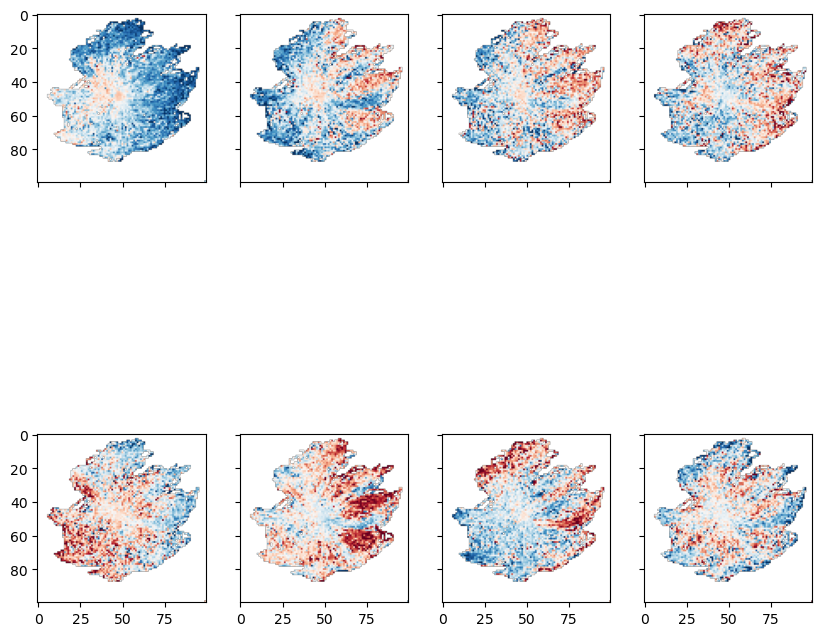

In [34]:
# val = val - np.nanmean(val)
n_r = int(np.sqrt(context_dim))
n_c = int(np.ceil(context_dim / n_r))
fig, ax = plt.subplots(nrows=n_r, ncols=n_c, figsize=(10, 10), sharex=True, sharey=True)
ax = np.ravel(ax)
for i, a in enumerate(ax):
    val = c_mid[:, :, i].T
    val = val / np.nanpercentile(np.abs(val), 97)

    a.imshow(val, cmap="RdBu", clim=(-1, 1))
    # plt.colorbar()

In [24]:
behavior_df.index.values
reach_intervals = reach_intervals[~np.isnan(reach_intervals).any(axis=1)]

In [ ]:
# Define decodeer type and fit

train_df = trials_df[trials_df.split == "train"]
train_df = train_df[train_df.ctr_hold_bump == False]
train_intervals = train_df.move_onset_time.values
train_rng = (-0.1, 0.5)
# train_rng = (-0.1, 1)
# train_rng = (-.5,1.5)
train_intervals = np.array(
    [train_intervals + train_rng[0], train_intervals + train_rng[1]]
).T

train_intervals[0]

t_feature = behavior_df.index.values
feature = behavior_df[["hand_vel_y", "hand_vel_x"]].values
feature = behavior_df[["hand_pos_x", "hand_pos_y"]].values

# feature = behavior_df[["hand_pos_y"]].values

print(np.nanmin(feature), np.nanmax(feature))
# analysis.initialize_decoder("knn", n_neighbors=30, weights='distance', metric='cosine')
analysis.initialize_decoder(
    model_type="knn",
    n_neighbors=300,
    # weights="uniform",
    weights="distance",
    # metric="cosine",
    metric="euclidean",
)

# analysis.initialize_decoder(
#     "discretized_regression", n_bins=100, max_iter=1000, balance_groups=True, multidim=False#True
# )

# analysis.initialize_decoder(
#     "linear",
# )
# analysis.fit_decoder(feature, t_feature, intervals=train_intervals,pca=False,interpolate=True, smooth_context=20)

analysis.fit_decoder(
    feature,
    t_feature,
    intervals=train_intervals,
    # pca=True,
    pca=False,
    # decode_dim = slice(0,3),
    interpolate=True,
    smooth_context=False,
    balance_features=True,
    balance_features_bins=int(20),
    balance_features_min_count=50,
)

-14.884146155345968 14.00538943303361


In [ ]:
# Decode on test set

test_df = trials_df[trials_df.split == "val"]
test_df = test_df[test_df.ctr_hold_bump == False]

# test_df = train_df

test_intervals = test_df.move_onset_time.values
test_rng = (-0.5, 1)
test_rng = (-0.1, 0.5)
test_intervals = np.array(
    [test_intervals + test_rng[0], test_intervals + test_rng[1]]
).T

# test_intervals = test_intervals[:5]

from tqdm import tqdm
from multiprocessing import Pool

# def predict_interval(interval):
#     return analysis.predict_decoder(
#         interval, interpolate=True, smooth_context=41
#     )

# predicted = []
# with Pool(processes=64) as pool:
#     for result in tqdm(
#         pool.imap_unordered(analysis.predict_decoder, test_intervals, chunksize=8),
#         total=len(test_intervals),
#     ):
#         predicted.append(result)
# predicted = [
#     analysis.predict_decoder(interval, interpolate=True, smooth_context=31)
#     for interval in tqdm(test_intervals)
# ]
predicted = []
for interval in tqdm(test_intervals):
    predicted.append(
        analysis.predict_decoder(interval, interpolate=True, smooth_context=1)
    )

test_directions = test_df.cond_dir.values
test_bump = test_df.ctr_hold_bump.values

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:04<00:00, 11.57it/s]


Text(0.5, 0, 'time from move onset (s)')

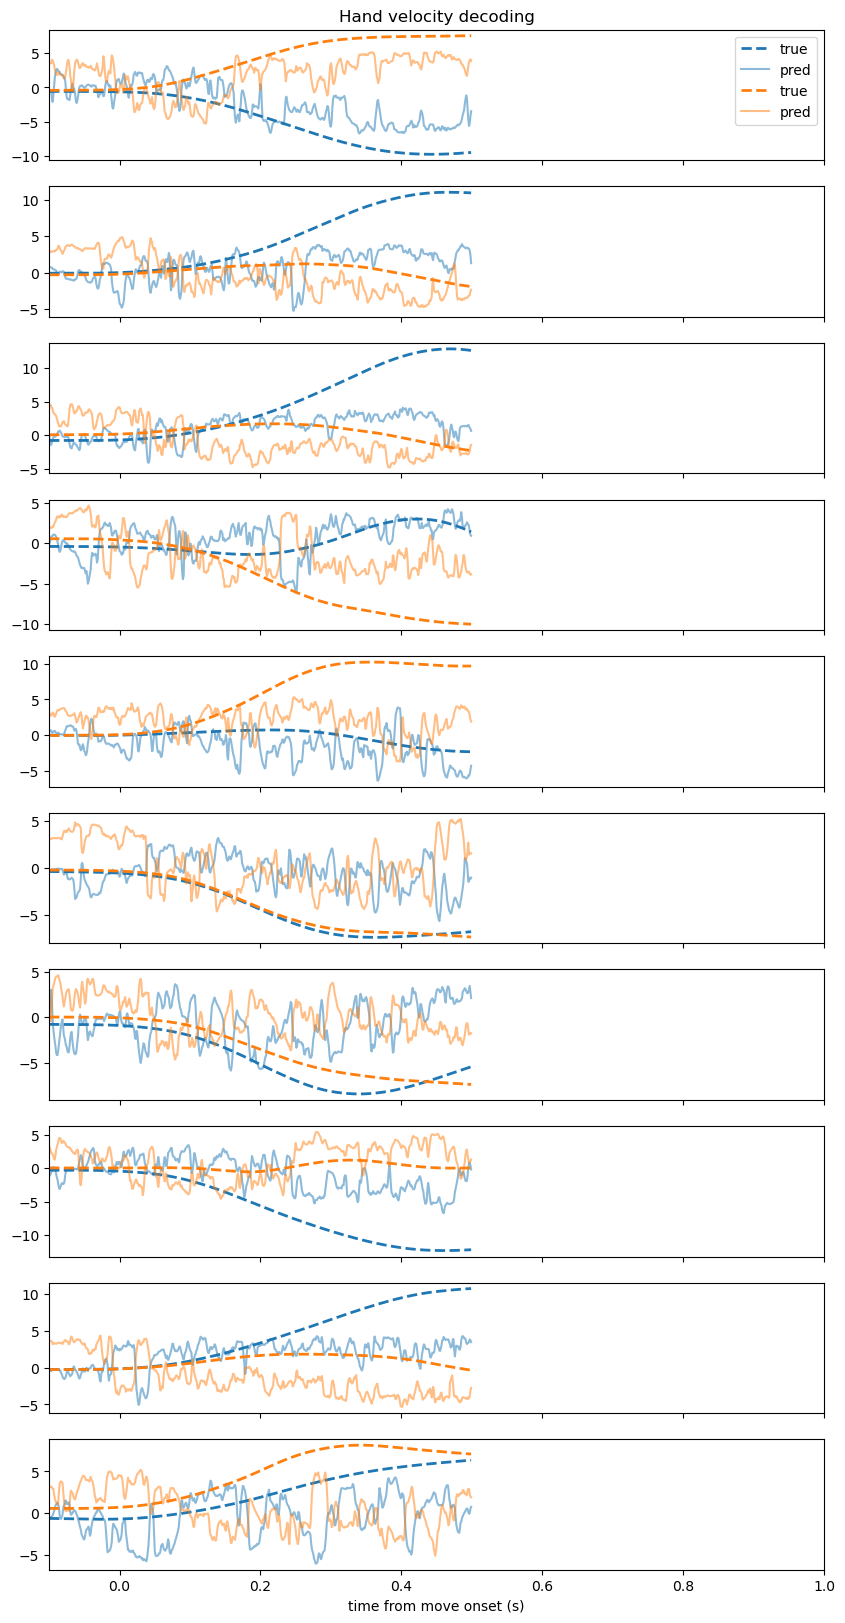

In [335]:
# Example result traces

fig, ax = plt.subplots(nrows=10, sharex=True, figsize=(10, 20))

ind = np.where(np.logical_and(test_directions == 0, test_bump == 0))[0]
ind = np.where(test_bump == 0)[0][10:]
for i, ind_i in enumerate(ind[:10]):
    t, pred = predicted[ind_i]

    # pred[:, 0] = np.convolve(
    #     pred[:, 0], np.hanning(21) / np.hanning(21).sum(), mode="same"
    # )
    # pred[:, 1] = np.convolve(
    #     pred[:, 1], np.hanning(21) / np.hanning(21).sum(), mode="same"
    # )
    # pred = gaussian_filter1d(pred, 10, axis=0, mode="nearest")

    if t.size == 0:
        continue
    ind_behavior = np.digitize(t, behavior_df.index.values) - 1

    for j in range(feature.shape[1]):
        ax[i].plot(
            behavior_df.index.values[ind_behavior] - t[0] + test_rng[0],
            feature[ind_behavior, j],
            color=f"C{j}",
            ls="--",
            lw=2,
            # s=1,
            label="true",
        )
        ax[i].plot(
            t - t[0] + test_rng[0], pred[:, j], color=f"C{j}", alpha=0.5, label="pred"
        )

ax[0].set_title("Hand velocity decoding")
# ax[0].set_title("Hand position decoding")
ax[0].legend(loc="upper right")
ax[0].set_xlim(-0.1, 1)
plt.xlabel("time from move onset (s)")
# for t,pred in predicted[:10]:
#     if t.size==0: continue
#     ind_behavior = np.digitize(t, behavior_df.index.values) - 1
#     plt.plot(t-t[0], pred, color='C0', alpha=0.3)
#     plt.scatter(behavior_df.index.values[ind_behavior]-t[0], feature[ind_behavior,0], color='k', s=1)

(-0.5, 1.0)

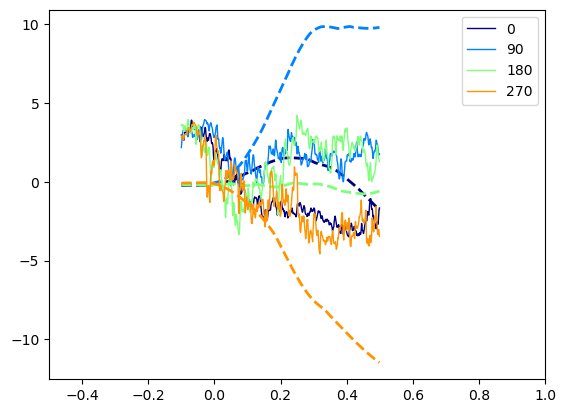

In [337]:
# Average results by direction
index = 1  # 0 for x, 1 for y
feature_name = "position"
index_names = {0: "x", 1: "y"}

for direction in [0, 90, 180, 270]:
    color = plt.cm.jet(direction / 360)
    ind = np.where(np.logical_and(test_directions == direction, test_bump == 0))[0]
    # for i, ind_i in enumerate(ind[:5]):
    #     t, pred = predicted[ind_i]
    #     if t.size == 0:
    #         continue
    #     # ind_behavior = np.digitize(t, behavior_df.index.values) - 1
    #     plt.plot(t - t[0] + test_rng[0], pred, color=color, alpha=0.1)

    mean_pred = np.mean(
        [predicted[ind_i][1] for ind_i in ind if predicted[ind_i][1].size > 0], axis=0
    )
    mean_t = predicted[ind[0]][0]
    plt.plot(
        mean_t - mean_t[0] + test_rng[0],
        mean_pred[:, index],
        color=color,
        lw=1,
        label=direction,
    )

    true_vals = []
    for ind_i in ind:
        t, pred = predicted[ind_i]
        if t.size == 0:
            continue
        ind_behavior = np.digitize(t, behavior_df.index.values) - 1
        true_vals.append(feature[ind_behavior, index])
    plt.plot(
        mean_t - mean_t[0] + test_rng[0],
        np.median(true_vals, axis=0),
        color=color,
        lw=2,
        ls="--",
    )

plt.legend()
plt.xlim(-0.5, 1)
# plt.xlim(-0.1, 0.5)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


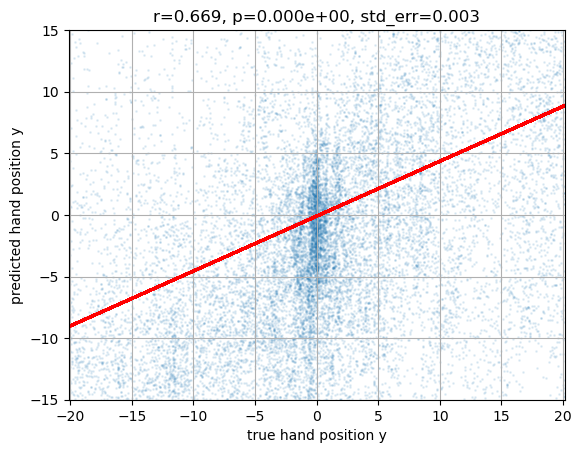

In [330]:
true_results = []
pred_results = []
index = 1
feature_name = "position"

index_names = {0: "x", 1: "y"}

for t_pred, pred in predicted:
    if t_pred.size == 0:
        continue
    ind_behavior = np.digitize(t_pred, t_feature) - 1
    true_results.extend(feature[ind_behavior, index])
    pred_results.extend(pred[:, index])
true_results = np.array(true_results)
pred_results = np.array(pred_results)

plt.scatter(true_results, pred_results, s=1, alpha=0.1)

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(true_results, pred_results)
plt.plot(true_results, slope * true_results + intercept, color="r", lw=2)
plt.xlabel(f"true hand {feature_name} {index_names[index]}")
plt.ylabel(f"predicted hand {feature_name} {index_names[index]}")
plt.title(f"r={r_value:.3f}, p={p_value:.3e}, std_err={std_err:.3f}")
plt.axis("equal")

lim = 15 if feature_name == "position" else 50
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid()
plt.show()

In [78]:
# residuals analysis
distance_error = np.sqrt(((true_results - pred_results) ** 2).sum(axis=-1))

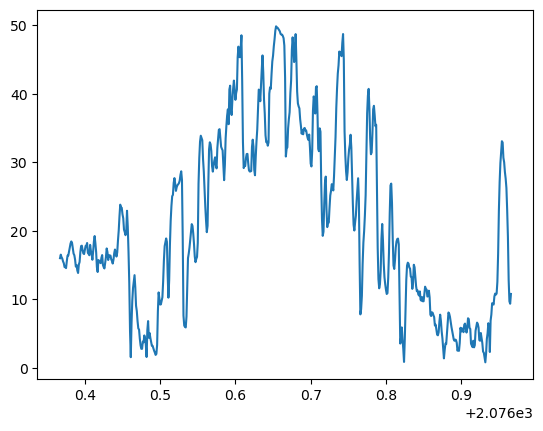

In [331]:
for t_pred, pred in predicted:
    if t_pred.size == 0:
        continue
    ind_behavior = np.digitize(t_pred, t_feature) - 1
    true_results = feature[ind_behavior, :]
    # break

distance_error = np.sqrt(((true_results - pred) ** 2).sum(axis=-1))

plt.plot(t_pred, distance_error)

Text(0.5, 1.0, 'Example hand position trajectories: true (dashed) vs predicted (solid)')

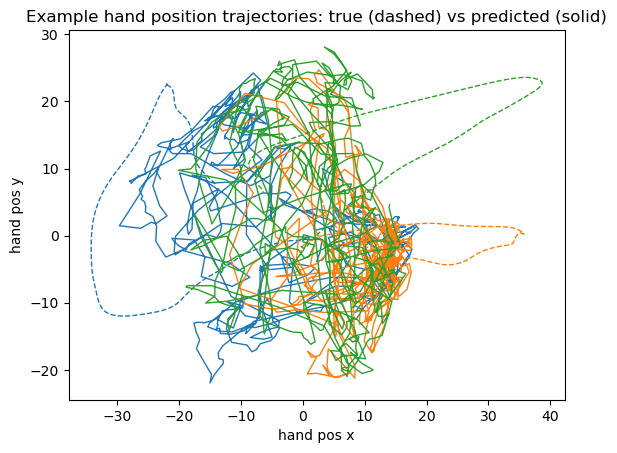

In [332]:
for n_i, i in enumerate(np.random.choice(len(predicted), size=3, replace=False)):

    t_pred, pred = predicted[i]
    ind_behavior = np.digitize(t_pred, behavior_df.index.values) - 1

    true_val = feature[ind_behavior, :]

    plt.plot(true_val[:, 0], true_val[:, 1], color=f"C{n_i}", ls="--", lw=1)
    plt.plot(pred[:, 0], pred[:, 1], color=f"C{n_i}", lw=1)

plt.xlabel("hand pos x")
plt.ylabel("hand pos y")
plt.title("Example hand position trajectories: true (dashed) vs predicted (solid)")

In [188]:
pred

array([], dtype=float64)

# Bin by feature


5it [00:15,  3.07s/it]/tmp/ipykernel_1933352/1654696050.py:22: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
6it [00:18,  3.10s/it]


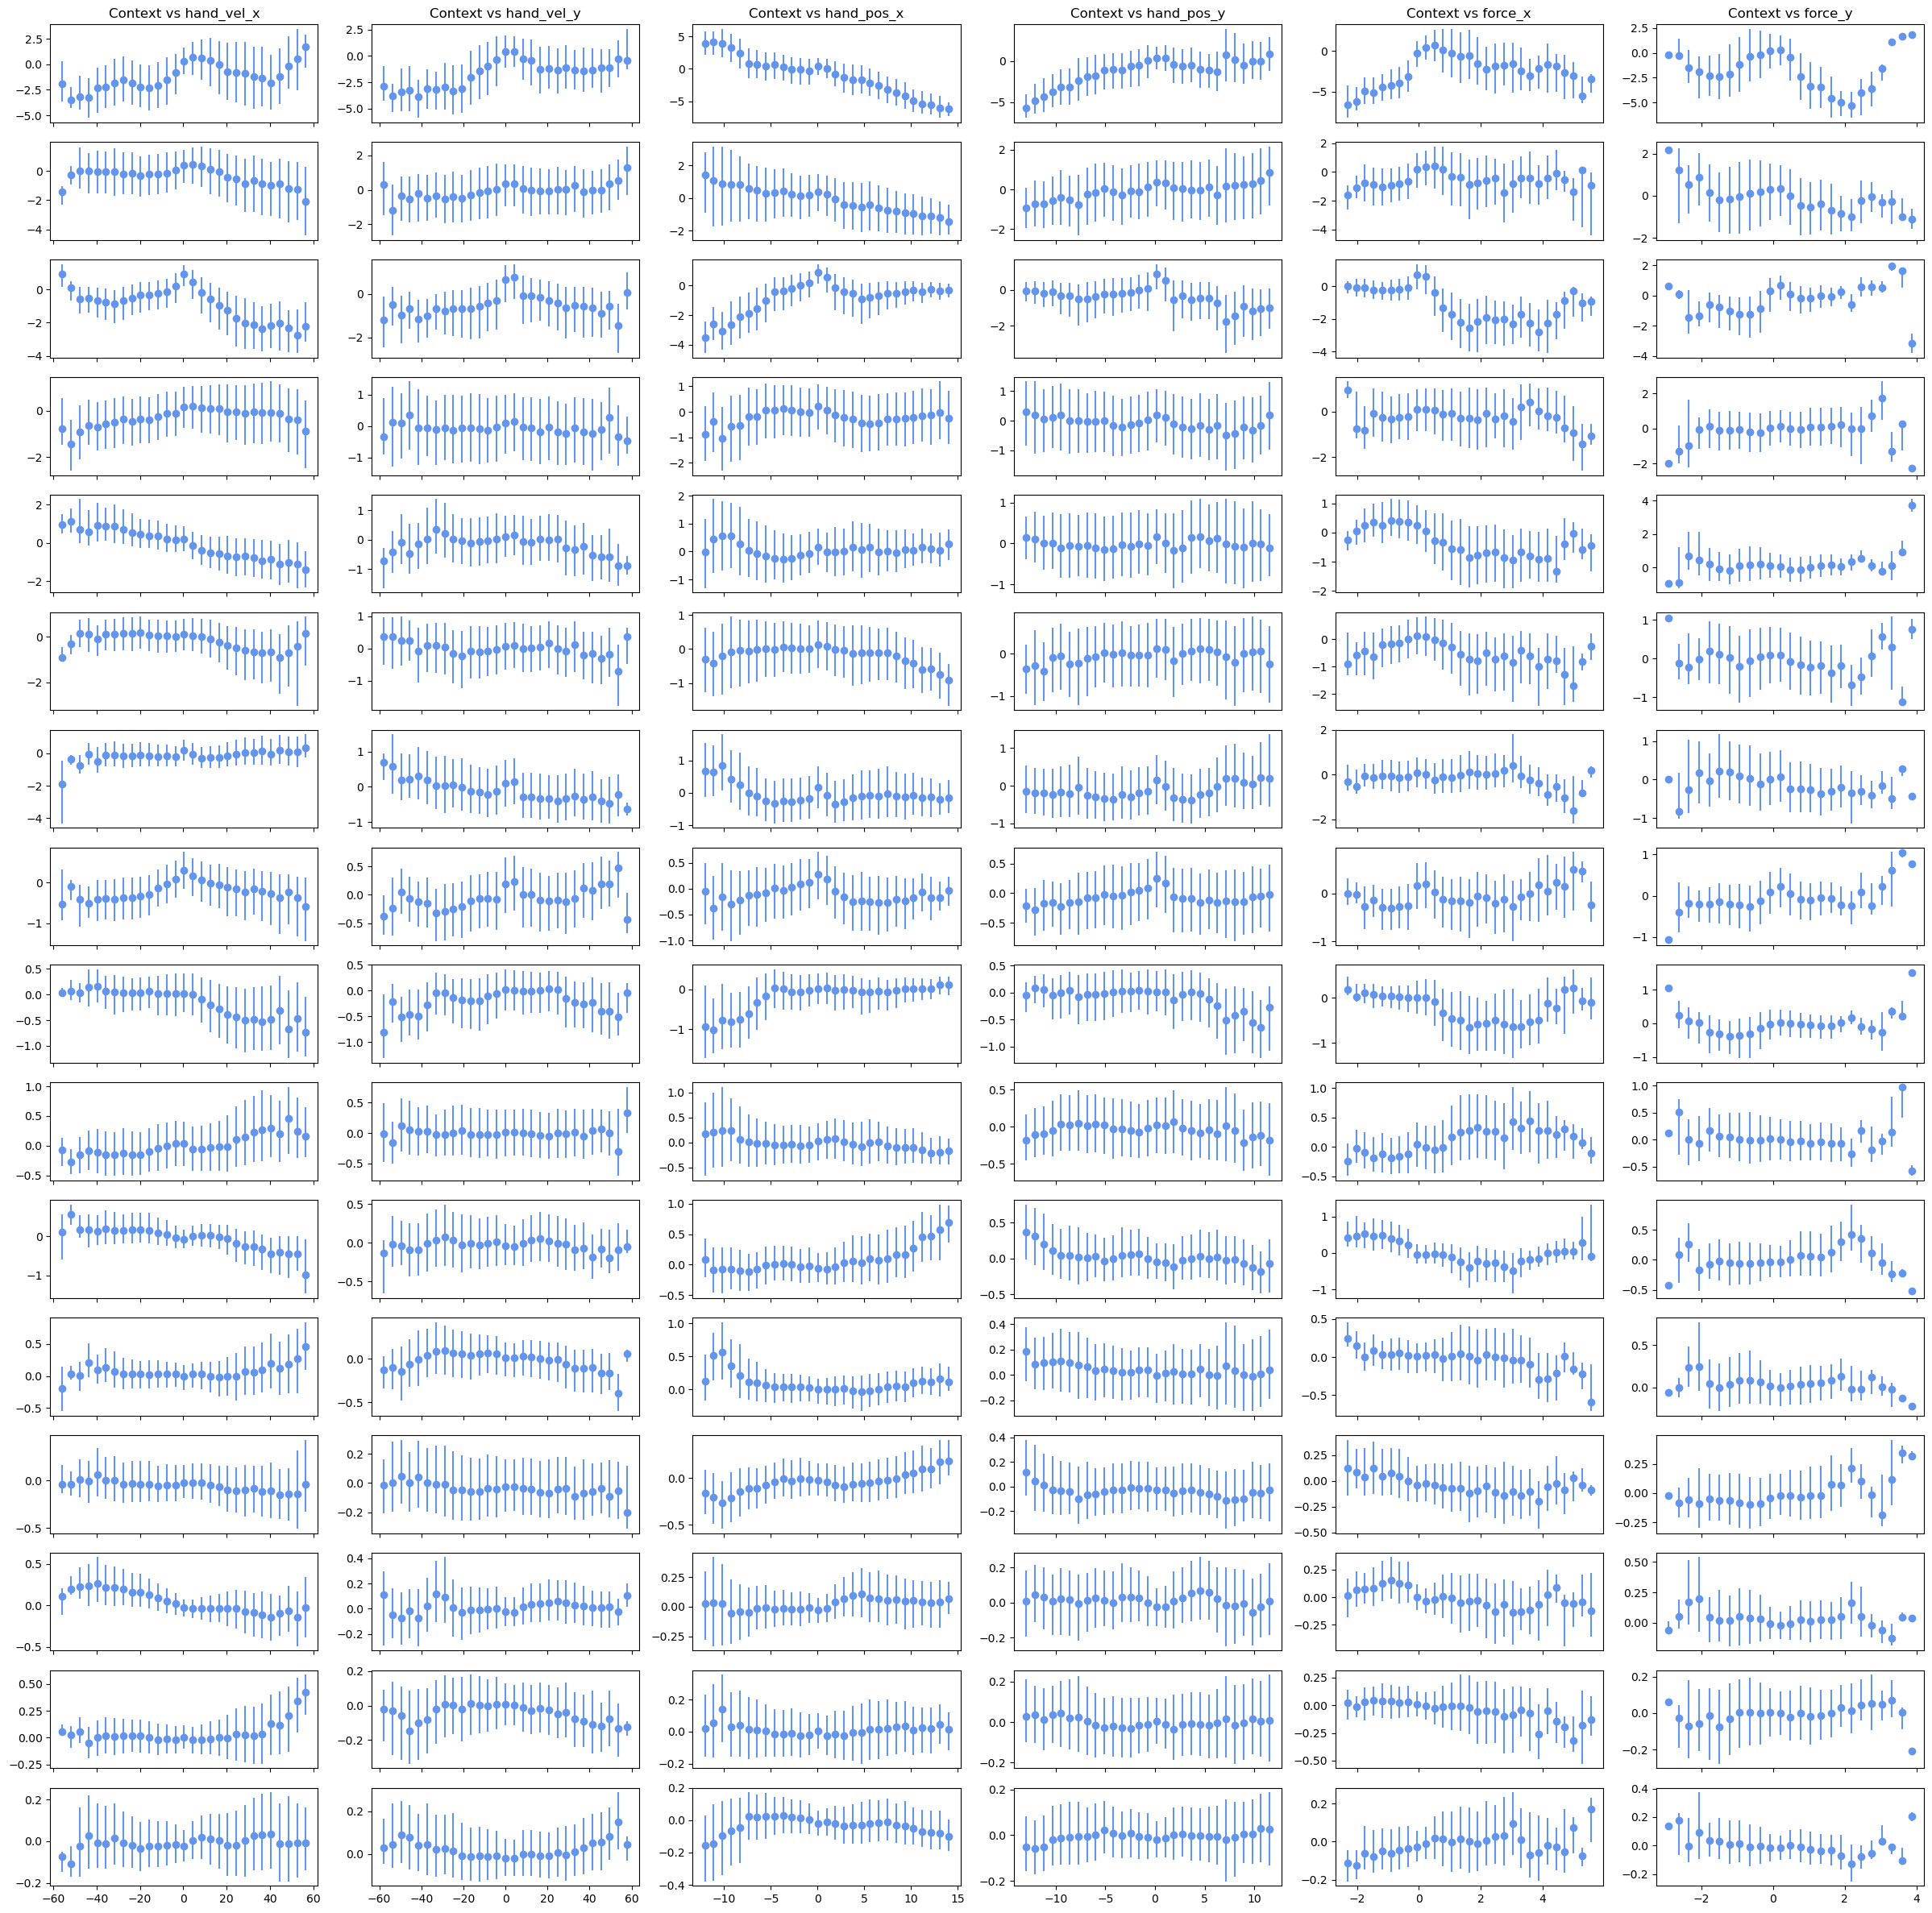

In [ ]:
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
starts = val.move_onset_time.values
reach_intervals = np.array([starts - 1, starts + 1.5]).T

feature_time = behavior_df.index.values
fig, ax_list = plt.subplots(
    nrows=context_dim, ncols=len(behavior_df.columns), sharex="col", figsize=(30, 30)
)


results = {}
for i_feature, feature_name in tqdm(enumerate(behavior_df.columns)):
    feature = behavior_df[feature_name].values

    ind = np.where(~np.isnan(feature))[0]
    context_binned, bins = analysis.bin_context_by_feature(
        feature[ind],
        feature_time[ind],
        pca=True,
        valid_intervals=reach_intervals,
        interpolated=True,
    )

    mid = np.array(
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in context_binned
        ]
    )
    lo = np.array(
        [
            (
                np.nanpercentile(b, 25, axis=0)
                if len(b)
                else np.nan * np.zeros(context_dim)
            )
            for b in context_binned
        ]
    )
    hi = np.array(
        [
            (
                np.nanpercentile(b, 75, axis=0)
                if len(b)
                else np.nan * np.zeros(context_dim)
            )
            for b in context_binned
        ]
    )
    results[feature_name] = {
        "bins": bins,
        "mid": mid,
        "lo": lo,
        "hi": hi,
    }

for i_feature, feature_name in enumerate(behavior_df.columns):
    bins = results[feature_name]["bins"]
    mid = results[feature_name]["mid"]
    lo = results[feature_name]["lo"]
    hi = results[feature_name]["hi"]

    ax_list[0, i_feature].set_title(f"Context vs {feature_name}")
    # for dat, loc in zip(mid, bins):
    for i, a in enumerate(ax_list[:, i_feature]):
        color = "cornflowerblue"
        a.scatter(bins[1:], mid[:, i], c=color)
        for j in range(len(bins) - 1):
            lo_j = lo[j, i]
            hi_j = hi[j, i]
            loc = bins[j + 1]
            a.vlines(loc, lo_j, hi_j, color=color)

    # break

In [220]:
ax_list.shape

(16, 3)

3it [00:09,  3.16s/it]


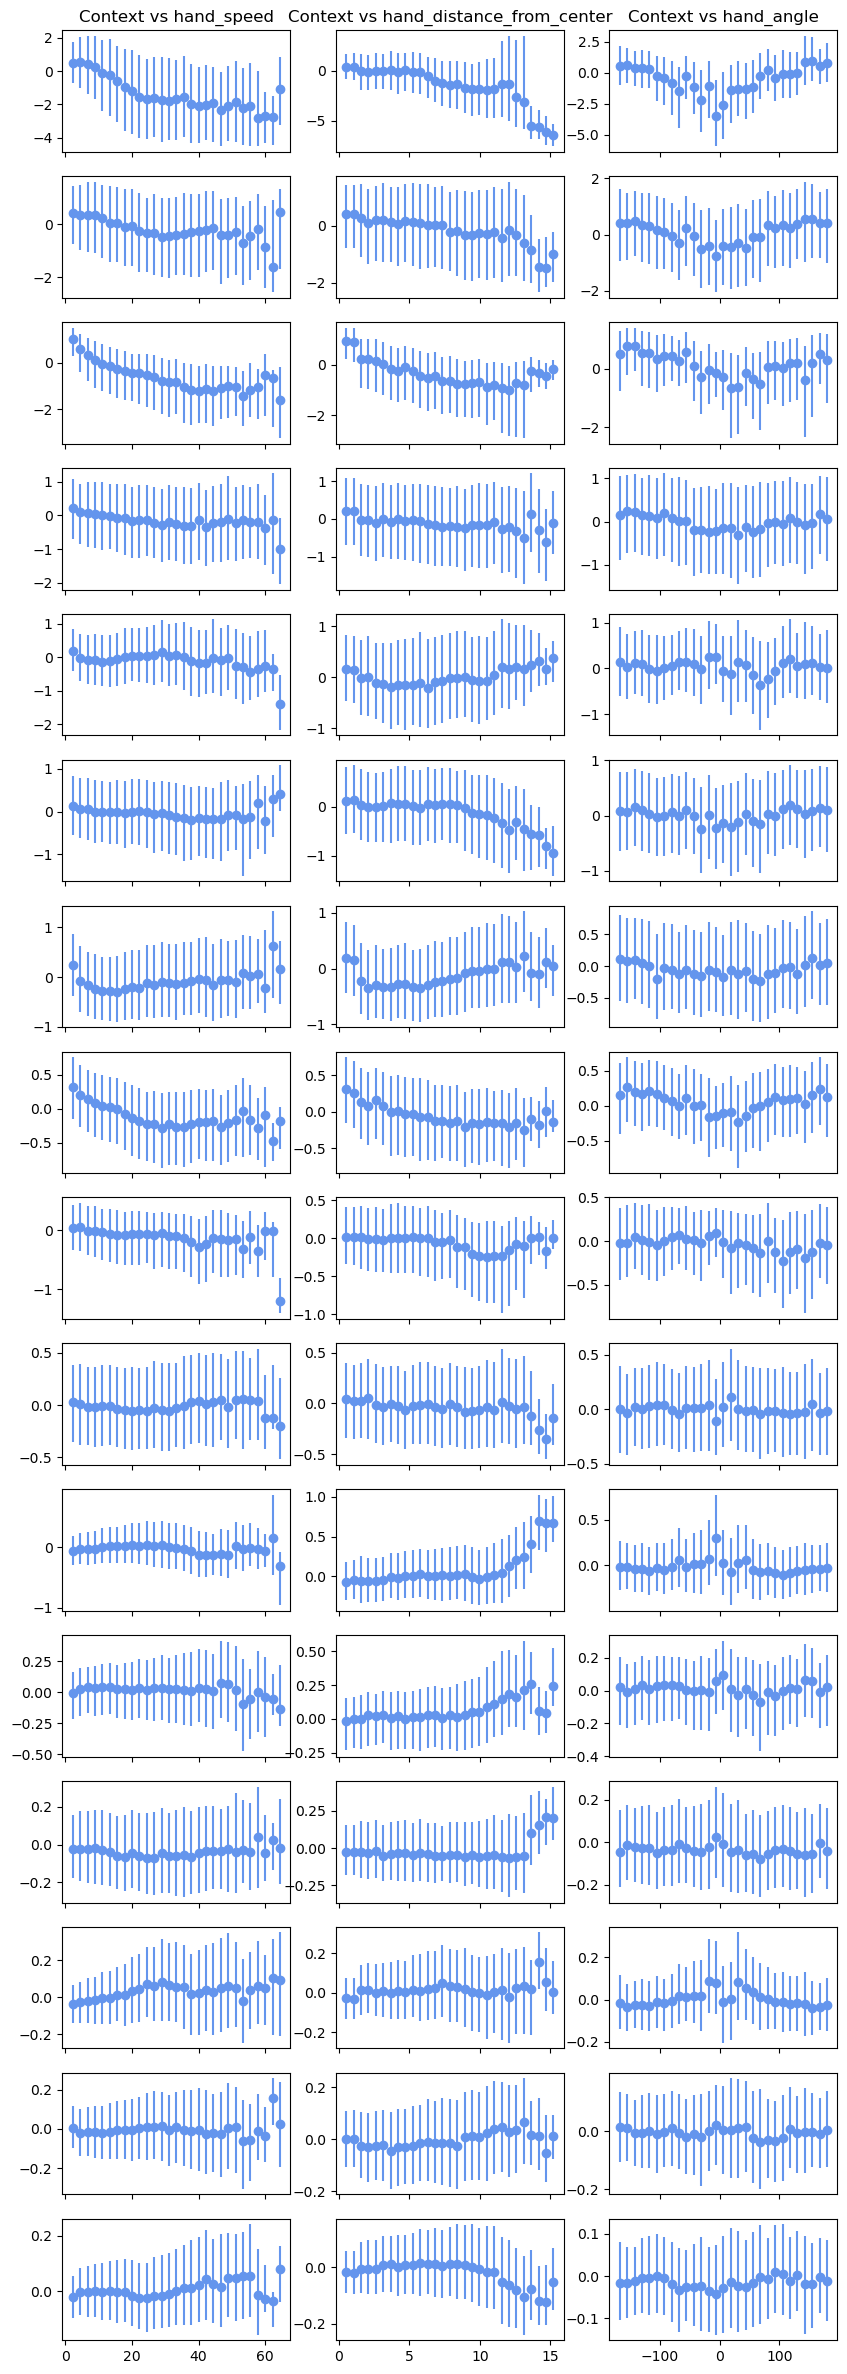

In [ ]:
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
starts = val.move_onset_time.values
reach_intervals = np.array([starts - 1, starts + 1.5]).T

feature_time = behavior_df.index.values
derived_features = {}
derived_features["hand_speed"] = np.sqrt(
    behavior_df["hand_vel_x"].values ** 2 + behavior_df["hand_vel_y"].values ** 2
)
derived_features["hand_distance_from_center"] = np.sqrt(
    behavior_df["hand_pos_x"].values ** 2 + behavior_df["hand_pos_y"].values ** 2
)
derived_features["hand_angle"] = (
    np.arctan2(behavior_df["hand_pos_y"].values, behavior_df["hand_pos_x"].values)
    * 180
    / np.pi
)

fig, ax_list = plt.subplots(
    nrows=context_dim, ncols=len(derived_features), sharex="col", figsize=(10, 30)
)

results = {}
for i_feature, feature_name in tqdm(enumerate(derived_features)):
    feature = derived_features[feature_name]

    ind = np.where(~np.isnan(feature))[0]
    context_binned, bins = analysis.bin_context_by_feature(
        feature[ind],
        feature_time[ind],
        pca=True,
        valid_intervals=reach_intervals,
        interpolated=True,
    )

    mid = np.array(
        [
            np.nanmedian(b, axis=0) if len(b) else np.nan * np.zeros(context_dim)
            for b in context_binned
        ]
    )
    lo = np.array(
        [
            (
                np.nanpercentile(b, 25, axis=0)
                if len(b)
                else np.nan * np.zeros(context_dim)
            )
            for b in context_binned
        ]
    )
    hi = np.array(
        [
            (
                np.nanpercentile(b, 75, axis=0)
                if len(b)
                else np.nan * np.zeros(context_dim)
            )
            for b in context_binned
        ]
    )
    results[feature_name] = {
        "bins": bins,
        "mid": mid,
        "lo": lo,
        "hi": hi,
    }

for i_feature, feature_name in enumerate(derived_features):
    bins = results[feature_name]["bins"]
    mid = results[feature_name]["mid"]
    lo = results[feature_name]["lo"]
    hi = results[feature_name]["hi"]

    ax_list[0, i_feature].set_title(f"Context vs {feature_name}")
    # for dat, loc in zip(mid, bins):
    for i, a in enumerate(ax_list[:, i_feature]):
        color = "cornflowerblue"
        a.scatter(bins[1:], mid[:, i], c=color)
        for j in range(len(bins) - 1):
            lo_j = lo[j, i]
            hi_j = hi[j, i]
            loc = bins[j + 1]
            a.vlines(loc, lo_j, hi_j, color=color)

    # break

In [234]:
val = trials_df.copy()
val = val[val.ctr_hold_bump == False]
starts = val.move_onset_time.values
starts = starts[~np.isnan(starts)]
reach_intervals = np.array([starts - 1, starts + 1.5]).T
starts

array([   4.075,   14.656,   18.508,   22.247,   44.107,   51.106,
         59.721,   66.443,   71.549,   79.118,   87.073,  112.859,
        122.917,  127.265,  138.991,  150.35 ,  158.541,  161.397,
        164.247,  170.838,  174.591,  178.84 ,  182.32 ,  195.353,
        198.564,  239.367,  242.946,  246.416,  250.528,  254.02 ,
        264.409,  267.657,  270.967,  272.919,  318.552,  322.361,
        325.206,  336.052,  339.561,  354.442,  358.759,  362.78 ,
        366.721,  381.072,  386.354,  391.361,  402.287,  425.086,
        436.569,  440.095,  442.79 ,  446.214,  449.739,  462.404,
        477.991,  499.11 ,  519.228,  526.404,  535.697,  538.966,
        544.817,  552.946,  558.171,  562.546,  566.625,  571.106,
        576.256,  578.972,  581.792,  584.425,  591.212,  594.478,
        597.365,  601.902,  612.297,  620.019,  628.705,  634.729,
        639.769,  646.982,  656.621,  659.979,  665.761,  669.504,
        671.922,  677.689,  685.269,  688.29 ,  691.307,  697.

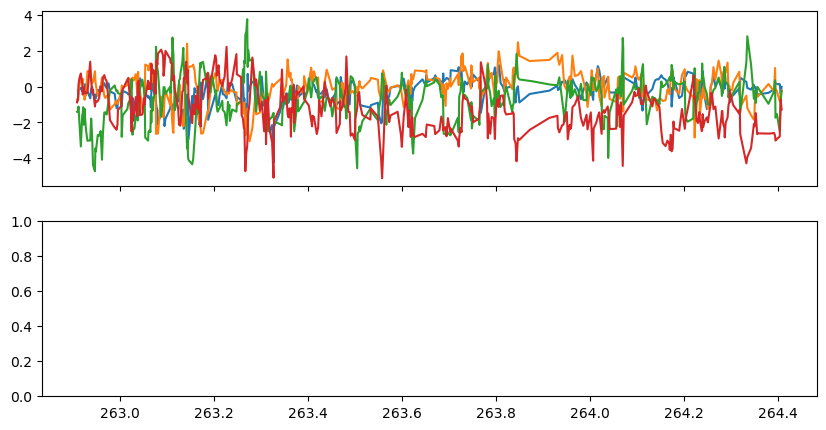

In [ ]:
# example_trace


t_0 = reach_intervals[30, 0]

t_rng = (-0.5, 1)

ind_behave = np.logical_and(
    behavior_df.index.values >= t_0 + t_rng[0],
    behavior_df.index.values <= t_0 + t_rng[1],
)

ind_context = np.logical_and(
    analysis.t_interp >= t_0 + t_rng[0], analysis.t_interp <= t_0 + t_rng[1]
)

fig, ax = plt.subplots(nrows=2, figsize=(10, 5), sharex=True)
for i, a in enumerate(range(context_dim)[:4]):
    ax[0].plot(
        analysis.t_interp[ind_context],
        analysis.c_interp[ind_context, i],
    )
    # a2 = a.twinx()
    # a2.plot(analysis.t_interp[ind_context]-t[0], analysis.c_pca_interp[ind_context,i], color='C1', label='context PC'+str(i+1))
    # a.set_ylabel('hand pos x')
    # a2.set_ylabel('context PC'+str(i+1))
    # a.axvline(0, color='k', ls=':', lw=1)
    # if i==0:
    #     a.legend(loc='upper left')
    #     a2.legend(loc='upper right')

In [231]:
ind_context.sum()

0